In [275]:
import numpy as np
import datetime
import pandas as pd

import time
import pickle
import os
from pathlib import Path

from math import log10, floor

import matplotlib.pyplot as plt
import matplotlib

def _format_k(prec):
    """
        format yaxis 10_000 as 10 k.
        _format_k(0)(1200, 1000.0) gives "1 k"
        _format_k(1)(1200, 1000.0) gives "1.2 k"
    """

    def inner(xval, tickpos):
        return f"${xval/1_000:.{prec}f}\,$k"

    return inner

round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1))


In [199]:
class CountriesByAge(object):
    def __init__(self):
        df = pd.read_csv("../DataByAge/world_population_by_age_UN.csv")
        self.df2020 = df[df["Reference date (as of 1 July)"] == 2020]
        
        
    def GetByCode(self,code):
        ages = self.df2020[self.df2020["Country code"] == code]
        
        age = {}
        for a in ["%d-%d"%(x,x+4) for x in range(0,96,5)]+["100+"]:
            age[a] = float(ages.iloc[0][a])*1000
        return age
        
cba = CountriesByAge()

class Country(object):
    def __init__(self,name,iso,code):
        self.name = name
        self.iso = iso
        self.code = code
        self.population = cba.GetByCode(self.code)
             
        # number of cases per day
        self.raw_data = {"cases":None,"deaths":None,"hospitalized":None,"ICU":None}
        self.data = {}
        self.weekly = {}
        
        # Different hooks along the pre-processing
        self.Load()
        self.Process()
        self.GenWeeklySeries()
        # Now contains a weekly dataseries
    
    def _splitAG(self,age_group,size=5):
        ages = []
        if "+" not in age_group:
            a,b = map(int,age_group.split("-"))
            for a in ["%d-%d"%(x,x+size-1) for x in range(a,b+1,size)]:
                ages.append(a)
        else:
            age = int(age_group.split("+")[0])
            ages = []
            for a in ["%d-%d"%(x,x+size-1) for x in range(age,96,size)]+["100+"]:
                ages.append(a)
        return ages
    
    def GetPopulation(self,age_group):
        total = np.sum(list(self.population.values()))
        ages = self._splitAG(age_group)
        n_ages,f_ages = {},{}
        for a in ages:
            p = self.population[a]
            n_ages[a] = p
            f_ages[a] = p/(1.*total)
        return n_ages,f_ages
            
        
        
    def Load(self):
        pass
    
    def Process(self):
        pass
    
    def GenWeeklySeries(self,data=None):
        if data == None:
            data = self.data
        for k,v in data.items():
            self.weekly[k] = v.resample('W',label='left').sum()
             
    def IsAvailable(self,key):
        return self.data.get(key,None) != None
                
class BasicCountry(Country):
    def __init__(self,name,iso,code):
        super(BasicCountry,self).__init__(name,iso,code)
        
    def Load(self):
        for k in self.raw_data.keys():
            fn_full = "../DataByAge/"+iso+"/"+k+".csv"
            try:
                df = pd.read_csv(fn_full,header=0,index_col=0)
                self.raw_data[k] = df
            except:
                pass
            
    def Process(self,data=None):
        if data == None:
            data = self.raw_data
            
        replace = {"80-":"80+","90-120":"90+"}
        unused = ["confirmed","deaths"]
        drop = ["Unknown","<50"]
        for k,v in data.items():
            if type(v) != type(None):
                columns = v.columns
            
                def replace_index(r):
                    if r in replace.keys():
                        r = replace[r]
                    return r
            
                columns = map(replace_index,columns)
                
                def remove_unused(r):
                    for u in unused:
                        if u in r:
                            r = r.replace(u,"").lstrip()
                    return r
                
                v.columns = map(remove_unused,columns)
                
                for d in drop:
                    if d in v.columns:
                        del v[d]
                
                # Convert the index to datetime
                v.index = pd.to_datetime(list(v.index))
                self.data[k] = v
                
class RemoveNamedDoubleIndex(BasicCountry):
    def __init__(self,name,iso,code):
        super(RemoveNamedDoubleIndex,self).__init__(name,iso,code)
        
    def Process(self):
        for k,v in self.raw_data.items():
            if type(v) != type(None):
                columns = v.columns
                
                def remove_double_index(r):
                    if "(" in r and ")" in r and "," in r:
                        r = r.split("'")[3]
                    return r
                        
                v.columns = map(remove_double_index,columns)
                
                def parse_datetime(s):
                    return datetime.datetime.strptime(s,'%d-%m-%Y')
                
                v.index = map(parse_datetime,v.index)
        super(RemoveNamedDoubleIndex,self).Process(self.raw_data)
    
class Switzerland(BasicCountry):
    def __init__(self,**kwargs):
        super(Switzerland,self).__init__("Switzerland","CHE",276)
        
    def Process(self):
        data = {}
        for k,v in self.raw_data.items():
            if type(v) != type(None):
                d = v.diff(axis=0)
                
                d = d.iloc[1:]
                data[k] = d
        super(Switzerland,self).Process(data)
        


In [200]:
class Germany(Country):
    def __init__(self,**kwargs):
        super(Germany,self).__init__("Germany","DE",276)
        
    def Load(self):
        pass
    
    def GenWeeklySeries(self,data=None):
        if data == None:
            print("Data is ignored for Germany")
        self.weekly = {}
        tindex = pd.date_range(start=datetime.datetime(2020,6,16),end=datetime.date(2020,10,6),freq="7D",closed='left')
        
        deaths = {}
        deaths_keys = ["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90-99","100+"]
        deaths[41] = [   1,   1,  10,  27,  84, 358, 924,2149,4204,1731,  53] # Sitreport Di 06.10.2020

        deaths[40] = [   1,   1,  10,  26,  83, 348, 923,2136,4158,1718,  52] # Sitreport Di 30.09.2020
        deaths[39] = [   1,   1,  10,  26,  82, 347, 914,2120,4137,1702,  52] # Sitreport Di 22.09.2020
        deaths[38] = [   1,   1,  10,  25,  82, 344, 911,2110,4124,1698,  52] # Sitreport Di 15.09.2020
        deaths[37] = [   1,   1,  10,  25,  81, 340, 908,2099,4115,1693,  52] # Sitreport Di 08.09.2020
        deaths[36] = [   1,   1,  10,  24,  81, 336, 901,2090,4109,1692,  52] # Sitreport Di 01.09.2020

        deaths[35] = [   1,   1,  10,  23,  81, 332, 895,2087,4101,1689,  52] # Sitreport Di 25.08.2020
        deaths[34] = [   1,   1,  10,  23,  79, 330, 893,2080,4082,1682,  50] # Sitreport Di 18.08.2020
        deaths[33] = [   1,   2,  10,  23,  79, 329, 891,2071,4065,1676,  50] # Sitreport Di 11.08.2020
        deaths[32] = [   1,   2,   9,  23,  79, 327, 888,2060,4045,1667,  50] # Sitreport Di 04.08.2020

        deaths[31] = [   1,   2,   9,  23,  78, 326, 881,2052,4033,1662,  50] # Sitreport Di 28.07.2020
        deaths[30] = [   1,   2,   9,  23,  76, 322, 877,2049,4022,1654,  50] # Sitreport Di 21.07.2020
        deaths[29] = [   1,   2,   9,  23,  76, 322, 874,2044,4010,1652,  51] # Sitreport Di 14.07.2020
        deaths[28] = [   1,   2,   9,  23,  75, 319, 865,2033,4001,1640,  51] # Sitreport Di 07.07.2020

        deaths[27] = [   1,   2,  10,  23,  72, 317, 857,2019,3982,1634,  51] # Sitreport Di 30.06.2020
        deaths[26] = [   1,   2,   9,  23,  69, 312, 848,2003,3954,1618,  51] # Sitreport Di 23.06.2020
        deaths[25] = [   1,   2,   9,  23,  69, 307, 835,1980,3922,1597,  50] # Sitreport Di 16.06.2020
        
        deaths_by_age = {}
        dkws = [x for x in deaths.keys()]
        for i,dk in enumerate(deaths_keys):
            a = []
            for j,w in enumerate(range(min(dkws),max(dkws)+1)):
                a.append(deaths[w][i])
            deaths_by_age[dk] = np.diff(np.array(a))
            
        deaths_by_age["90+"] = deaths_by_age["90-99"]+deaths_by_age["100+"]
        del deaths_by_age["90-99"]
        del deaths_by_age["100+"]
        
        df = pd.DataFrame.from_dict(deaths_by_age)
        df.index = tindex
        self.weekly["deaths"] = df
        
        cases = {}
        # cases starting KW25 source sit-rep table, 1 week less than SurvStat
        cases["100+"] = np.array([1,0,0,0,2,0,1,5,2,1,1,1,1,6,3,3,0])
        cases["90-99"]= np.array([36,26,24,15,25,18,38,16,24,17,28,23,43,67,90,102,0])

        # Via survstat
        cases["0-9"] = np.array([159,135,141,145,140,161,150,190,273,284,224,233,227,291,301,312,22])+np.array([176,140,124,115,138,151,199,285,408,380,351,318,325,351,384,400,34])
        cases["10-19"] = np.array([192,145,104,100,150,191,250,364,544,575,478,431,497,514,572,662,34])+np.array([240,167,138,148,192,248,365,544,740,874,830,766,827,1024,1032,1261,112])
        cases["20-29"] = np.array([375,255,258,236,301,376,520,736,1163,1547,1327,1242,1276,1505,1572,1666,149])+np.array([393,323,315,226,307,410,508,606,833,1194,1213,1148,1233,1474,1429,1705,141])
        cases["30-39"] = np.array([402,331,260,259,295,381,424,510,697,940,853,933,930,1203,1291,1460,120])+np.array([374,299,226,202,251,360,382,513,643,759,711,647,690,897,993,1104,96])
        cases["40-49"] = np.array([447,271,214,189,253,321,428,484,636,714,654,642,682,834,851,1001,96])+np.array([375,277,222,181,233,335,385,451,571,689,605,607,690,871,885,1145,115])
        cases["50-59"] = np.array([315,263,185,172,207,291,350,416,471,558,536,549,667,891,989,1157,106])+np.array([184,202,156,116,175,242,285,307,324,428,350,387,551,753,854,1062,100])
        cases["60-69"] = np.array([120,108,110,93,109,153,150,202,192,238,244,246,337,491,526,646,79])+np.array([69,65,62,62,70,85,85,120,110,119,130,127,224,291,299,423,24])
        cases["70-79"] = np.array([57,40,38,56,60,62,90,92,79,96,91,108,151,258,267,327,33])+np.array([65,57,40,40,42,57,71,55,71,66,67,75,145,180,229,282,21])
        cases["80+"] = np.array([144,111,100,72,91,103,168,140,163,105,110,109,257,371,419,558,49])
        
        # build 90+, 80-89
        cases["80-89"] = cases["80+"]-cases["90-99"]-cases["100+"]
        cases["90+"] = cases["90-99"]+cases["100+"]
        
        del cases["80+"]
        del cases["90-99"]
        del cases["100+"]
        
        for k,v in cases.items():
            cases[k] = v[:-1]
        tindex = pd.date_range(start=datetime.datetime(2020,6,16),end=datetime.date(2020,10,6),freq="7D",closed='left')
        df = pd.DataFrame.from_dict(cases)
        df.index = tindex
        self.weekly["cases"] = df


In [201]:
cntrs = {}
cntrs["CZ"] = {"name":"Czech Republic","class":RemoveNamedDoubleIndex,"code":203}
cntrs["NL"] = {"name":"Netherlands","class":RemoveNamedDoubleIndex,"code":528}
cntrs["PRT"] = {"name":"Portugal","class":RemoveNamedDoubleIndex,"code":620}
cntrs["BE"] = {"name":"Belgium","class":RemoveNamedDoubleIndex,"code":56}

cntrs["DE"] = {"class":Germany,}
cntrs["CHE"] = {"class":Switzerland}

countries = {}
for iso,cntry in cntrs.items():
    countries[iso] = cntry["class"](name=cntry.get("name",None),iso=iso,code=cntry.get("code",None))


print(countries)

Data is ignored for Germany
{'CZ': <__main__.RemoveNamedDoubleIndex object at 0x11239ddd0>, 'NL': <__main__.RemoveNamedDoubleIndex object at 0x12112ee10>, 'PRT': <__main__.RemoveNamedDoubleIndex object at 0x1274eb1d0>, 'BE': <__main__.RemoveNamedDoubleIndex object at 0x127776650>, 'DE': <__main__.Germany object at 0x1241511d0>, 'CHE': <__main__.Switzerland object at 0x1264cf490>}


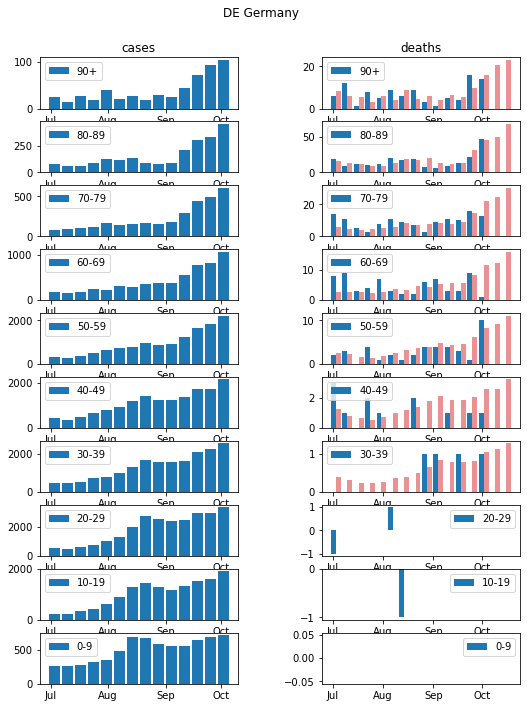

In [202]:
def ifr(s):
    return {"90+":.22,"80-89":.15,"80+":.17,"70-79":.05,"60-69":.015,"50-59":.005,"40-49":.0015,"30-39":.0005}.get(s,0.)

def ShowWeeklyOverview(country,start=datetime.datetime(2020,6,15)):
    
    data = country.weekly
    fig = plt.figure(figsize=(7.5,10))
    fig.subplots_adjust(wspace=0.425,hspace=0.25,left=0.09,right=0.98,top=0.91,bottom=0.04)
    
    possible_keys = ["cases","hospitalized","ICU","deaths"]
    keys = [x for x in possible_keys if x in data.keys()]
    n_ags = [len(data[x].columns) for x in keys]
    
    gs = fig.add_gridspec(max(n_ags), len(keys))
    
    
    
    splts = {}
    for i,k in enumerate(keys):
        splts[k] = {}
        for j,c in enumerate(data[k].columns[::-1]):
            ax = fig.add_subplot(gs[j,i])
            splts[k][c] = ax
            if j == 0:
                ax.set_title(k)
            # Formating
            ax.xaxis.set_major_locator( matplotlib.dates.MonthLocator() )
            ax.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b') )
    
    for i,k in enumerate(keys):
        for j,c in enumerate(data[k].columns):
            ds = data[k][c]
            ds = ds[start:]
            
            ax = splts[k][c]
            ax.bar(ds.index[2:],ds[2:],label=c,width={"deaths":3}.get(k,6),align="edge")
            if k == "cases":
                dx = splts["deaths"].get(c,None)
                if dx != None:
                    dx.bar(ds.index+datetime.timedelta(days=3+14),ds*ifr(c),width=3,align="edge",alpha=.5,color="tab:red")
                    
            ax.legend()
            
#            ax.set_xticks(xticks)
            
            
            
    
    fig.suptitle(country.iso+" "+country.name)
    fig.savefig("plots/"+country.iso+".pdf")

#for k,v in countries.items():
 #   ShowWeeklyOverview(v)
#ShowWeeklyOverview(countries["CHE"])
ShowWeeklyOverview(countries["DE"])

0-4 1.0000000000000067e-05
5-9 1.778279410038934e-05
10-14 3.162277660168398e-05
15-19 5.623413251903522e-05
20-24 0.0001000000000000005
25-29 0.0001778279410038931
30-34 0.00031622776601683924
35-39 0.0005623413251903512
40-44 0.0010000000000000033
45-49 0.0017782794100389282
50-54 0.0031622776601683876
55-59 0.005623413251903502
60-64 0.010000000000000018
65-69 0.017782794100389254
70-74 0.031622776601683826
75-79 0.05623413251903493
80-84 0.1
85-89 0.1778279410038922
90-94 0.3162277660168377
95-99 0.5623413251903484


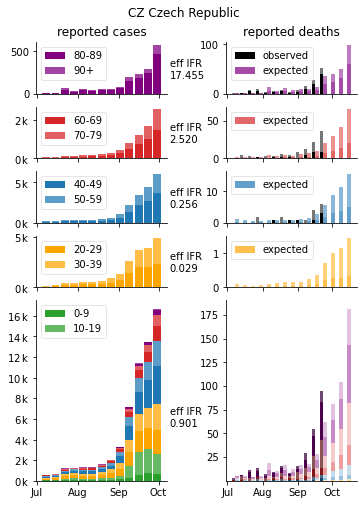

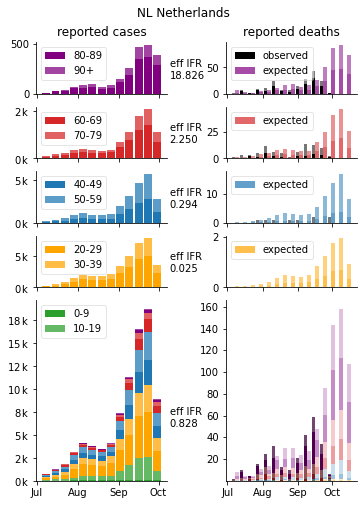

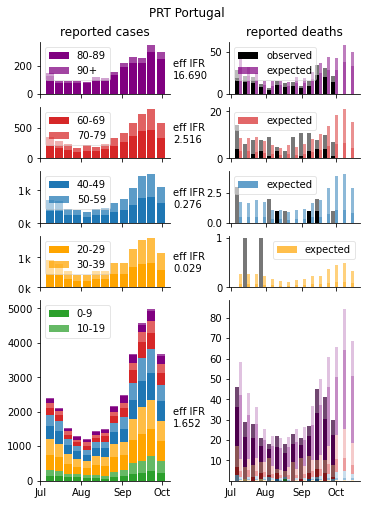

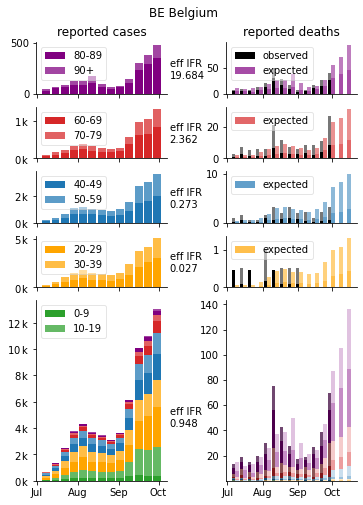

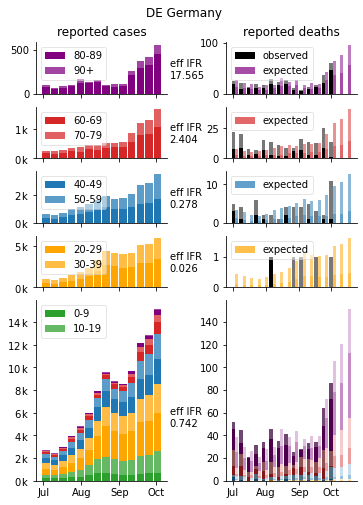

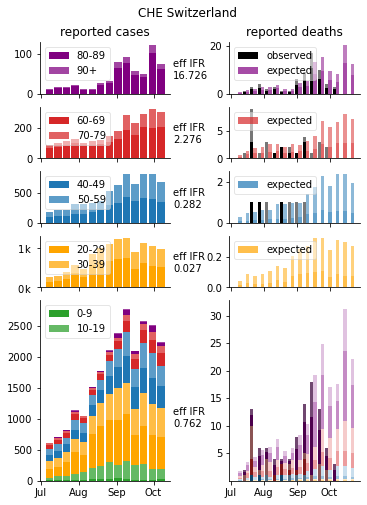

In [292]:
def ifr(s):
    # a82 - 10.0%
    f = 0
    if "+" in s:
        if s == "80+":
            f = .15
        elif s == "90+":
            f = .2
        elif s == "100+":
            f = .6
    else:
        a,b = map(int,s.split("-"))
        c = (a+b)/2
        g = np.power(10,1/20.)
        f = .1*np.power(g,(c-82))
    return f

for i in range(0,100,5):
    print("%d-%d"%(i,i+4),ifr( "%d-%d"%(i,i+4) ))
        
def PrettyWeeklyOverview(country,start=datetime.datetime(2020,6,15)):
    alpha2 = .73
    
    data = country.weekly
    fig = plt.figure(figsize=(5,7))
    fig.subplots_adjust(wspace=0.45,hspace=0.25,left=0.09,right=0.98,top=0.91,bottom=0.04)
    
    fig.suptitle(country.iso+" "+country.name)
    
    a_groups = ["80+","60-79","40-59","20-39","0-19"]
    g_colors = ["purple","tab:red","tab:blue","orange","tab:green"]

    possible_keys = ["cases","deaths"]
    keys = [x for x in possible_keys if x in data.keys()]
    
    gs = fig.add_gridspec(len(a_groups)+2, len(keys))
    cx,dx = fig.add_subplot(gs[len(a_groups)-1:,0]),fig.add_subplot(gs[len(a_groups)-1:,1])
    
    age_strata_5y = ["%d-%d"%(x,x+4) for x in range(0,96,5)]+["100+"]
    
    splts = {}
    for i,k in enumerate(keys):
        splts[k] = {}
        for j,c in enumerate(a_groups[:-1]):
            ax = fig.add_subplot(gs[j,i])
            splts[k][c] = ax
            if j == 0:
                ax.set_title("reported "+k)
            # Formating
            ax.xaxis.set_major_locator( matplotlib.dates.MonthLocator() )
            ax.set_xticklabels([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        splts[k][a_groups[-1]] = {0:cx,1:dx}[i]
            
    for tx in [cx,dx]:
        tx.xaxis.set_major_locator( matplotlib.dates.MonthLocator() )
        tx.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b') )
        tx.spines['top'].set_visible(False)
        tx.spines['right'].set_visible(False)
    
    # Distribute Cases and deaths by pop (and IFR) scaling to 5y age-groups
    d5y = {}
    for dkey,scaling in zip(["cases","deaths","est_deaths"],[lambda x : 1,ifr,ifr]):
        d = data[{"est_deaths":"cases"}.get(dkey,dkey)]
        t = {}
        d5y[dkey] = t
        for dag in d.keys(): # Iterate over the dataset's age_groups
            # Prepare to split age_groups
            n_pop,f_pop = country.GetPopulation(dag)
            f_pop_sum = np.sum(list(f_pop.values()))
            age_k = f_pop.keys()
            f = np.array([f_pop[k] for k in age_k])/f_pop_sum
            s = np.array([scaling(k) for k in age_k]) * f
            s_sum = np.sum(s)
            if dkey != "est_deaths":
                s = s/s_sum # Scaling of sub-age-groups (5 years) within AgeGroup from Data
            for j,k in enumerate(age_k):
                t[k] = d[dag]*s[j]
    
    # Combine Data to 10y strata
    d10y = {}
    for dkey in ["cases","deaths","est_deaths"]:
        t = {}
        d10y[dkey] = t
        for i,pag in enumerate(a_groups):
            for j,sag in enumerate(country._splitAG(pag,10)):
                for k,tag in enumerate(country._splitAG(sag)):
                    if sag not in t:
                        t[sag] = d5y[dkey][tag].clip(lower=0)
                    else:
                        t[sag] += d5y[dkey][tag].clip(lower=0)
  
    # Plot Cases and deaths in 10y age-groups
    ycc = np.zeros(len(d10y["cases"]["0-9"][start:]))
    ydd = np.zeros(len(d10y["deaths"]["0-9"][start:]))
    yee = np.zeros(len(d10y["est_deaths"]["0-9"][start:]))
    for i,pag in enumerate(a_groups[::-1]):
        c = g_colors[::-1][i]
        
        ax,bx = splts["cases"][pag],splts["deaths"][pag]
        yc = np.zeros(len(d10y["cases"]["0-9"][start:]))
        yd = np.zeros(len(d10y["deaths"]["0-9"][start:]))
        ye = np.zeros(len(d10y["est_deaths"]["0-9"][start:]))
        sags = country._splitAG(pag,10)
        for j,sag in enumerate(sags):
            cases = d10y["cases"][sag][start:]
            deaths = d10y["deaths"][sag][start:]
            est_deaths = d10y["est_deaths"][sag][start:]
                        
            a = [1,alpha2][min(j,1)]
            l = sag
            if l == "90-99":
                l = "90+"
            elif l == "100+":
                l = None
                
            ax.bar(cases.index[2:],cases[2:],bottom=yc[2:],width=6,align="edge",color=c,alpha=a,label=l)
            
            dc,l,l2 ="black",None,None
            if i == 0:
                dc = c
            elif i == len(a_groups) -1 and j == 0:
                l2 = "observed"
            if j == 0:
                l = "expected"
            
            bx.bar(deaths.index[2:],deaths[2:],bottom=yd[2:],width=3,align="edge",color=dc,alpha=a*a,label=l2)
            bx.bar(est_deaths.index+datetime.timedelta(days=3+14),est_deaths,bottom=ye,width=3,align="edge",color=c,alpha=a*.7,label=l)
            
            ax.legend(fancybox=True, framealpha=0.5)
            if i != 0:
                bx.legend(fancybox=True, framealpha=0.5)
            
            if i != 0:
                cx.bar(cases.index[2:],cases[2:],bottom=ycc[2:],width=6,align="edge",color=c,alpha=a)
                dx.bar(deaths.index[2:],deaths[2:],bottom=ydd[2:],width=3,align="edge",color=c,alpha=a*a)
                dx.bar(est_deaths.index+datetime.timedelta(days=3+14),est_deaths,bottom=yee,width=3,align="edge",color=c,alpha=a*a*.45)

            
            yc += cases
            ycc += cases
            yd += deaths
            ydd += deaths
            ye += est_deaths
            yee += est_deaths
        
        if i != 0:
            eff_IFR = np.sum(ye[2:])/np.sum(yc[2:])*100
            s = "eff IFR\n%.3f"%eff_IFR
            ax.text(1.02,.3,s,transform=ax.transAxes)
            
        for tx in [ax,bx]:
            prec = 1. / (np.log10(tx.get_ylim()[1]) - 1.3)
            if prec < .6 and prec >= 0:
                 tx.yaxis.set_major_formatter(
                    matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
                    )
            
    dx.bar(deaths.index[2:],ydd[2:],width=3,align="edge",color="black",alpha=.4)
    
    eff_IFR = np.sum(yee[2:])/np.sum(ycc[2:])*100
    s = "eff IFR\n%.3f"%eff_IFR
    cx.text(1.02,.3,s,transform=cx.transAxes)
    
 #   cases5y,deaths5y = {},{}
  #  for g in data["cases"]:
   #     n_pop,f_pop = country.GetPopulation(g)
    #    f_pop_sum = np.sum(list(f_pop.values()))
     #   for ag5 in n_pop.keys():
#            cases5y[ag5] = 
        #        print(g,np.sum(list(n_pop.values())),np.sum(list(f_pop.values())))
        
      #      print(g,ag5,f_pop[ag5],f_pop_sum)
    
#    for a_groups
    
    fig.savefig("plots/"+country.iso+".pdf")

if True:
    for k,v in countries.items():
        PrettyWeeklyOverview(v)
else:
    PrettyWeeklyOverview(countries["DE"])

In [204]:
print(countries["DE"].GetPopulation("80+"))
print(countries["DE"].GetPopulation("60+"))
print(countries["DE"].GetPopulation("5-34"))

({'80-84': 3259094.0, '85-89': 1635049.0, '90-94': 758147.0, '95-99': 204159.0, '100+': 19295.0}, {'80-84': 0.03889878902216887, '85-89': 0.019515063416982812, '90-94': 0.00904883387861481, '95-99': 0.002436731762869366, '100+': 0.00023029471815871167})
({'60-64': 5820703.0, '65-69': 4823439.0, '70-74': 3833823.0, '75-79': 3637591.0, '80-84': 3259094.0, '85-89': 1635049.0, '90-94': 758147.0, '95-99': 204159.0, '100+': 19295.0}, {'60-64': 0.06947277309513177, '65-69': 0.057569967611336516, '70-74': 0.04575844453254141, '75-79': 0.04341632516826464, '80-84': 0.03889878902216887, '85-89': 0.019515063416982812, '90-94': 0.00904883387861481, '95-99': 0.002436731762869366, '100+': 0.00023029471815871167})
({'5-9': 3822225.0, '10-14': 3811645.0, '15-19': 4118970.9999999995, '20-24': 4553436.0, '25-29': 4823925.0, '30-34': 5441865.0}, {'5-9': 0.04562001705696718, '10-14': 0.04549373988059407, '15-19': 0.04916181733863212, '20-24': 0.05434735736064947, '25-29': 0.057575768245336265, '30-34': 0.